In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Import math functions at the beginning
from math import radians, cos, sin, sqrt, atan2

import geopandas as gpd
import shapely
import skmob
from skmob.measures.individual import jump_lengths
from skmob.tessellation import tilers
from skmob.preprocessing import detection, clustering
from skmob.preprocessing import filtering
from skmob.preprocessing import compression

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
import warnings
warnings.simplefilter("ignore")
import os

In [4]:
# Load data
os.chdir('C:/Users/Owner/Downloads/')
df = pd.read_csv("Galapagos Tortoise Movement Ecology Programme_2009-2018.csv", sep=',', parse_dates=[2])

# Data preprocessing
new_cols = pd.Series(df.columns.values).str.replace(pat=r"[-:]", repl="_", regex=True)
tortoise = df.set_axis(labels=new_cols, axis=1)
tortoise.drop(tortoise.index[tortoise["manually_marked_outlier"].notna()], inplace=True)
tortoise.drop(columns=["manually_marked_outlier"], inplace=True)
tortoise.drop(index=tortoise.index[tortoise.isna().any(axis=1)], inplace=True)

cols = ['event_id', 'timestamp', 'location_long', 'location_lat',
       'eobs_temperature', 'ground_speed', 'heading', 'height_above_ellipsoid',
       'individual_local_identifier', 'individual_taxon_canonical_name']
tortoise.drop(columns=tortoise.columns.difference(cols), inplace=True)

# Timezone conversion
tortoise.insert(loc=2, column="timestamp_UTC", value=tortoise['timestamp'].apply(lambda x: x.tz_localize(tz='UTC')))
tortoise.insert(loc=3, column="timestamp_local", value=tortoise["timestamp_UTC"].apply(lambda x: x.tz_convert(tz='US/Pacific')))
tortoise.sort_values(by=["individual_local_identifier", "timestamp_local"], inplace=True)

tortoise.insert(loc=4, column="minute_diff", value=tortoise.groupby(['individual_local_identifier'])["timestamp_local"].diff().apply(lambda x: x / np.timedelta64(1, 'm')).fillna(0).astype('int64'))
tortoise['year'] = tortoise["timestamp_local"].dt.year
tortoise['month'] = tortoise["timestamp_local"].dt.month
tortoise['date'] = tortoise["timestamp_local"].dt.date
tortoise.reset_index(drop=True, inplace=True)

# trying the Haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c  # in kilometers
    return distance

# calculate distances
def calculate_distances(group):
    group['prev_lat'] = group['location_lat'].shift(1)
    group['prev_long'] = group['location_long'].shift(1)
    group['distance_km'] = group.apply(
        lambda row: haversine(row['location_lat'], row['location_long'], row['prev_lat'], row['prev_long']),
        axis=1
    )
    return group

# Apply the distance calculation to each tortoise group
tortoise = tortoise.groupby('individual_local_identifier', group_keys=False).apply(calculate_distances)

# Drop the temporary columns used for distance calculation
tortoise.drop(columns=['prev_lat', 'prev_long'], inplace=True)

# Group by tortoise ID and date, summing up the distances
daily_movement = tortoise.groupby(['individual_local_identifier', 'date'], as_index=False)['distance_km'].sum()
daily_movement.rename(columns={'distance_km': 'total_distance_km'}, inplace=True)

# Tortoises to keep
tortoise_names = ['Alison', 'Marilyn', 'Kitty', 'Connor', 'Helber', 'Christian', 'Steve Devine']

# Filter the daily_movement DataFrame
filtered_daily_movement = daily_movement[daily_movement['individual_local_identifier'].isin(tortoise_names)]

# Migration threshold
migration_threshold = 3  # km

# Column to flag migration days
filtered_daily_movement['is_migrating'] = filtered_daily_movement['total_distance_km'] > migration_threshold

# Initialize a dictionary to store migration start and end dates
migration_dates = {}

# Loop through each tortoise to identify start and end dates
for tortoise_id, group in filtered_daily_movement.groupby('individual_local_identifier'):
    migrating_days = group[group['is_migrating']]
    if not migrating_days.empty:
        start_date = migrating_days['date'].min()
        end_date = migrating_days['date'].max()
        migration_dates[tortoise_id] = {'start': start_date, 'end': end_date}
    else:
        migration_dates[tortoise_id] = {'start': None, 'end': None}

# Convert to DataFrame for easier viewing
migration_summary = pd.DataFrame.from_dict(migration_dates, orient='index').reset_index()
migration_summary.rename(columns={'index': 'tortoise_id'}, inplace=True)

# Display the summary of migration dates
print(migration_summary)

    tortoise_id       start         end
0        Alison  2018-06-25  2018-06-25
1     Christian        None        None
2        Connor        None        None
3        Helber        None        None
4         Kitty        None        None
5       Marilyn        None        None
6  Steve Devine        None        None


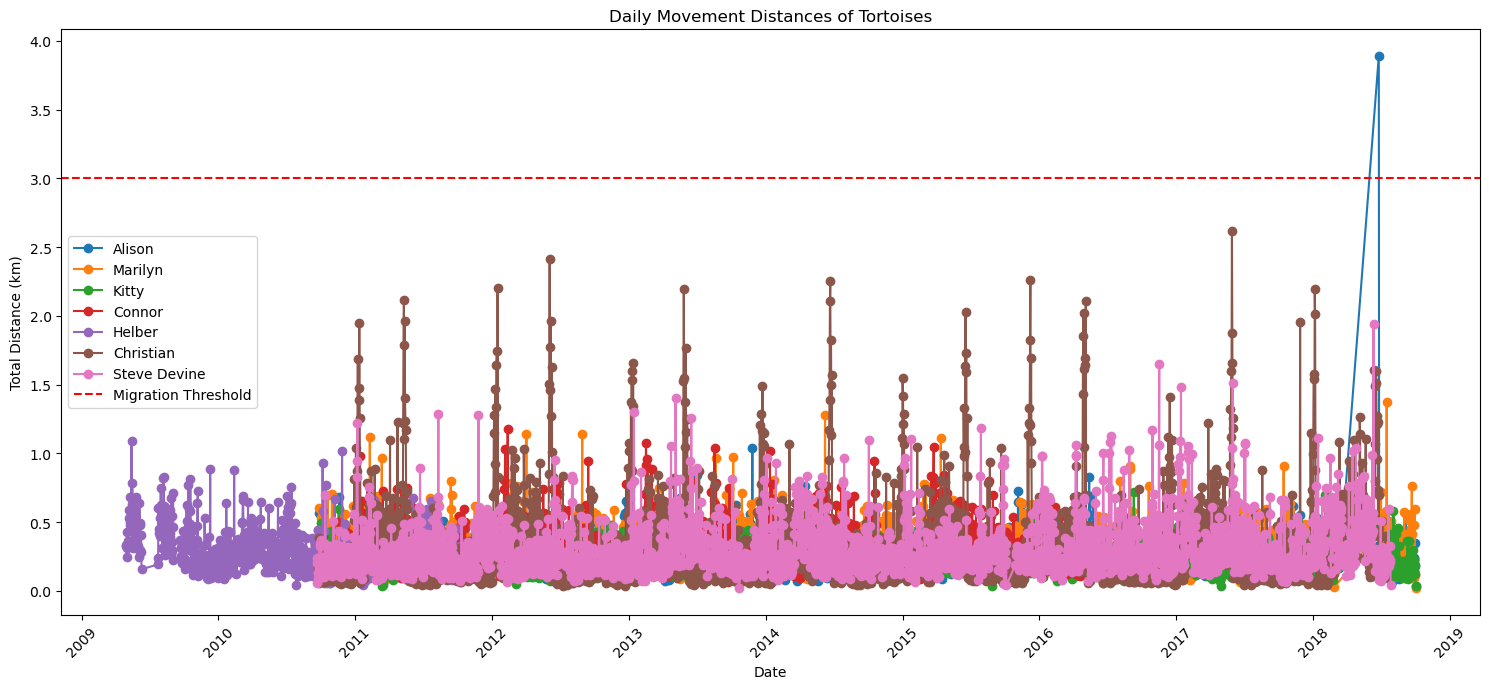

In [5]:
plt.figure(figsize=(15, 7))
for tortoise_id in tortoise_names:
    subset = daily_movement[daily_movement['individual_local_identifier'] == tortoise_id]
    plt.plot(subset['date'], subset['total_distance_km'], marker='o', label=tortoise_id)

plt.axhline(y=migration_threshold, color='r', linestyle='--', label='Migration Threshold')
plt.title('Daily Movement Distances of Tortoises')
plt.xlabel('Date')
plt.ylabel('Total Distance (km)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:

# migration threshold (did not work with 6km)
migration_threshold = 1.5  # km

# create a column to flag migration days
filtered_daily_movement['is_migrating'] = filtered_daily_movement['total_distance_km'] > migration_threshold

# initialize a dictionary to store migration start and end dates
migration_dates = {}

# loop through each tortoise to identify start and end dates
for tortoise_id, group in filtered_daily_movement.groupby('individual_local_identifier'):
    migrating_days = group[group['is_migrating']]
    if not migrating_days.empty:
        start_date = migrating_days['date'].min()
        end_date = migrating_days['date'].max()
        migration_dates[tortoise_id] = {'start': start_date, 'end': end_date}
    else:
        migration_dates[tortoise_id] = {'start': None, 'end': None}

# Convert to DataFrame for easier viewing
migration_summary = pd.DataFrame.from_dict(migration_dates, orient='index').reset_index()
migration_summary.rename(columns={'index': 'tortoise_id'}, inplace=True)

# Display the summary of migration dates
print(migration_summary)

    tortoise_id       start         end
0        Alison  2018-06-25  2018-06-25
1     Christian  2011-01-08  2018-06-18
2        Connor        None        None
3        Helber        None        None
4         Kitty        None        None
5       Marilyn        None        None
6  Steve Devine  2016-11-16  2018-06-11


In [7]:
# Define the list of tortoise names you want to keep
tortoise_names = ['Alison', 'Marilyn', 'Kitty', 'Connor', 'Helber', 'Christian', 'Steve Devine']

# Filter the DataFrame for the specific tortoises
filtered_tortoise = tortoise[tortoise['individual_local_identifier'].isin(tortoise_names)]

# Radius of Gyration Function
def radius_of_gyration(group):
    # Calculate the centroid (mean position)
    centroid_lat = group['location_lat'].mean()
    centroid_long = group['location_long'].mean()
    
    # Calculate distances from the centroid
    group['distance_from_centroid'] = group.apply(
        lambda row: haversine(row['location_lat'], row['location_long'], centroid_lat, centroid_long),
        axis=1
    )
    
    # Calculate radius of gyration
    R_g = np.sqrt((group['distance_from_centroid'] ** 2).mean())
    return R_g

# Calculate radius of gyration for each tortoise in the filtered data
radii_of_gyration = filtered_tortoise.groupby('individual_local_identifier').apply(radius_of_gyration).reset_index()
radii_of_gyration.columns = ['tortoise_id', 'radius_of_gyration_km']

# Display the results
print(radii_of_gyration)


    tortoise_id  radius_of_gyration_km
0        Alison               1.498891
1     Christian               4.305262
2        Connor               1.656300
3        Helber               1.937885
4         Kitty               0.105030
5       Marilyn               1.067251
6  Steve Devine               3.367076


After studying Alison in class, I wonder if Marilyn, Connor and Alison migrate every other year, while Christian and Steve Devine migrate every year.